In [1]:
!pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=3301372 sha256=e8463fe860c7a971cb4b7e51c687d5bac47ebb4935d86f29b6188608ef29cf2e
  Stored in directory: /root/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
Successfully built dlib


In [89]:
import torch
import torch.nn as nn
import torchaudio.transforms as T
import torch.nn.functional as F
import librosa
import os
import dlib
import glob
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [90]:
class BiLSTMForAudio(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=True):
        super(BiLSTMForAudio, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True).to(DEVICE)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return out.to(DEVICE)

class UpsamplingResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsamplingResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1).to(DEVICE)
        self.bn1 = nn.BatchNorm2d(out_channels).to(DEVICE)
        self.relu = nn.ReLU(inplace=True).to(DEVICE)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest').to(DEVICE)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1).to(DEVICE)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1).to(DEVICE)
        
        self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1).to(DEVICE)  # 1x1 conv for matching dimensions

    def forward(self, x):
        skip = self.conv_skip(self.upsample(x))

        x = self.upsample(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return (x + skip).to(DEVICE)  

class ASubnet(nn.Module):
    def __init__(self, input_size, initial_feature_dim):
        super(ASubnet, self).__init__()
        self.fc = nn.Linear(input_size, initial_feature_dim*4*4).to(DEVICE)

        self.upres_blocks = nn.Sequential(
            UpsamplingResBlock(initial_feature_dim, initial_feature_dim),
            UpsamplingResBlock(initial_feature_dim, initial_feature_dim // 2),
            UpsamplingResBlock(initial_feature_dim // 2, initial_feature_dim // 2),
            UpsamplingResBlock(initial_feature_dim // 2, initial_feature_dim // 4),
            UpsamplingResBlock(initial_feature_dim // 4, initial_feature_dim // 4),
            UpsamplingResBlock(initial_feature_dim // 4, initial_feature_dim // 4),
        ).to(DEVICE)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 4, 4)
        x = self.upres_blocks(x)
        return x.to(DEVICE)

In [91]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1).to(DEVICE)
        self.bn1 = nn.BatchNorm2d(channels).to(DEVICE)
        self.relu = nn.ReLU(inplace=True).to(DEVICE)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1).to(DEVICE)
        self.bn2 = nn.BatchNorm2d(channels).to(DEVICE)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return x.to(DEVICE)
    
class Convolution(nn.Module):
    def __init__(self, inChannel, outChannel, kernel_size = 3, padding=1, stride = 1, upsampling=False, downsampling=False, sampling_factor=2):
        super(Convolution, self).__init__()
        self.upsampling = upsampling
        self.downsampling = downsampling
        self.conv = nn.Conv2d(inChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=stride).to(DEVICE)
        self.upsample = nn.Upsample(scale_factor=sampling_factor, mode='nearest').to(DEVICE)
        self.downsample = nn.Conv2d(outChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=sampling_factor).to(DEVICE)
        self.batchnorm = nn.BatchNorm2d(outChannel).to(DEVICE)
        self.relu = nn.ReLU(inplace=True).to(DEVICE)
    
    def forward(self, x):
        if(self.upsampling):
            x = self.upsample(x)
        x = self.relu(self.batchnorm(self.conv(x)))
        if(self.downsampling):
            x = self.downsample(x)
        return x.to(DEVICE)
    
class VSubnet(nn.Module):
    def __init__(self):
        super(VSubnet, self).__init__()
        self.initial_layers = nn.Sequential(
            Convolution(3, 64),
            Convolution(64, 128, downsampling=True),
            Convolution(128, 256, downsampling=True),
        ).to(DEVICE)
        self.res_blocks = nn.Sequential(
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
        ).to(DEVICE)
        self.final_layers = nn.Sequential(
            Convolution(256, 128, upsampling=True),
            Convolution(128, 64, upsampling=True),
        ).to(DEVICE)

    def forward(self, x):
        x = self.initial_layers(x)
        x = self.res_blocks(x)
        x = self.final_layers(x)
        return x.to(DEVICE)


In [92]:
class Convolution(nn.Module):
    def __init__(self, inChannel, outChannel, kernel_size = 3, padding=1, stride = 1, upsampling=False, downsampling=False, sampling_factor=2):
        super(Convolution, self).__init__()
        self.upsampling = upsampling
        self.downsampling = downsampling
        self.conv = nn.Conv2d(inChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=stride).to(DEVICE)
        self.upsample = nn.Upsample(scale_factor=sampling_factor, mode='nearest').to(DEVICE)
        self.downsample = nn.Conv2d(outChannel, outChannel, kernel_size=kernel_size, padding=padding, stride=sampling_factor).to(DEVICE)
        self.batchnorm = nn.BatchNorm2d(outChannel).to(DEVICE)
        self.relu = nn.ReLU(inplace=True).to(DEVICE)
    
    def forward(self, x):
        if(self.upsampling):
            x = self.upsample(x)
        x = self.relu(self.batchnorm(self.conv(x)))
        if(self.downsampling):
            x = self.downsample(x)
        return x.to(DEVICE)
        
class LSubnet(nn.Module):
    def __init__(self):
        super(LSubnet, self).__init__()
        self.layers = nn.Sequential(
            Convolution(3, 64),
            Convolution(64, 128, downsampling=True),
            Convolution(128, 256, downsampling=True),
            Convolution(256, 256, downsampling=True),
            Convolution(256, 256, downsampling=True),
            Convolution(256, 256, upsampling=True),
            Convolution(256, 256, upsampling=True),
            Convolution(256, 128, upsampling=True),
            Convolution(128, 64, upsampling=True),
        ).to(DEVICE)

    def forward(self, x):
        return (self.layers(x)).to(DEVICE)


In [93]:
class SpatialAttentionFusion(nn.Module):
    def __init__(self):
        super(SpatialAttentionFusion, self).__init__()
        self.speech_conv = nn.Conv2d(64 * 2, 64, kernel_size=7, padding=3).to(DEVICE)
        self.landmark_conv = nn.Conv2d(64 * 2, 64, kernel_size=7, padding=3).to(DEVICE)
        self.fusion_conv = nn.Conv2d(64 * 3, 64, kernel_size=1).to(DEVICE)
        self.sigmoid = nn.Sigmoid().to(DEVICE)

    def forward(self, speech_features, video_features, landmark_features):
        speech_video = torch.cat([speech_features, video_features], dim=1)
        landmark_video = torch.cat([landmark_features, video_features], dim=1)
        speech_map = self.sigmoid(self.speech_conv(speech_video))
        landmark_map = self.sigmoid(self.landmark_conv(landmark_video))
        landmark_map = landmark_map * landmark_features
        speech_map = speech_map * speech_features

        fused_features = torch.cat([speech_map, video_features, landmark_map], dim=1)
        fused_features = self.fusion_conv(fused_features)
        return fused_features.to(DEVICE)

In [94]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    ).to(DEVICE)
    return conv.to(DEVICE)

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2).to(DEVICE)
        self.down_conv_1 = double_conv(64, 64).to(DEVICE)
        self.down_conv_2 = double_conv(64, 128).to(DEVICE)
        self.down_conv_3 = double_conv(128, 256).to(DEVICE)
        self.down_conv_4 = double_conv(256, 512).to(DEVICE)
        self.down_conv_5 = double_conv(512, 1024).to(DEVICE)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_1 = double_conv(1024, 512).to(DEVICE)
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_2 = double_conv(512, 256).to(DEVICE)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_3 = double_conv(256, 128).to(DEVICE)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        ).to(DEVICE)
        self.up_conv_4 = double_conv(128, 64).to(DEVICE)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=3,
            kernel_size=1
        ).to(DEVICE)

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)   
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        tanh = nn.Tanh()
        x = tanh(x)
        # print(x.shape)
        return x.to(DEVICE)

In [98]:
predictor_path =  "/kaggle/input/frames-obama/shape_predictor_68_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
# win = dlib.image_window()

def face_predictor(file):
    img = dlib.load_rgb_image(file)

    # win.clear_overlay()
    # win.set_image(img)

    dets = detector(img, 1)
    image_size=(256, 256)
    image = torch.zeros(3, *image_size).to(DEVICE)
    if len(dets) == 0 : 
        points = []
    for k, d in enumerate(dets):
        shape = predictor(img, d)
#         win.add_overlay(shape)
        points = shape.parts()
        break
    for point in points:
        x, y = point.x, point.y
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            image[:, y, x] = 1
    return image.to(DEVICE)

In [99]:
hidden_size = 256  
num_layers = 3 

def extract_mfcc(audio_path):
    audio_signal, sample_rate = librosa.load(audio_path, sr=16000)
    n_mfcc = 13 
    n_fft = 400  
    hop_length = 160 
    n_mels = 40  
    window_size = 21 

    mfcc_transform = T.MFCC(
        sample_rate=1,
        n_mfcc=n_mfcc,
        melkwargs={
            'n_fft': n_fft,
            'n_mels': n_mels,
            'hop_length': hop_length
        }
    )
    
    mfccs = mfcc_transform(torch.Tensor(audio_signal).unsqueeze(0)) 
    mfccs = torch.nan_to_num(mfccs, nan=0)
    mfccs = mfccs.transpose(1, 2) 
        
    return mfccs.to(DEVICE)

In [100]:
class ObamaDataset(Dataset):
    def __init__(self, src_img_dir, target_img_dir, audio_dir, transform=None):
        self.src_img_dir = src_img_dir
        self.target_img_dir = target_img_dir
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
            return len(os.listdir(self.src_img_dir)) 

    def __getitem__(self, idx):
        ids = str(idx)
        if idx<5294:
            file_name_comp = f"obama000_30kbps_h264_frame{idx:04d}.png"
            file_name_orig = f"obama000_frame{idx:04d}.png"
            audio = "obama000.wav"
        elif idx<(11388):
            file_name_comp = f"obama001_30kbps_h264_frame{(idx-5294):04d}.png"
            file_name_orig = f"obama001_frame{(idx-5294):04d}.png"
            audio = "obama001.wav"
        else:
            file_name_comp = f"obama002_30kbps_h264_frame{(idx-11388):04d}.png"
            file_name_orig = f"obama002_frame{(idx-11388):04d}.png"
            audio = "obama002.wav"
        src_img_path = os.path.join(self.src_img_dir, file_name_comp)
        target_img_path = os.path.join(self.target_img_dir, file_name_orig)
        audio_path = os.path.join(self.audio_dir, audio)
        src_image = np.array(Image.open(src_img_path).convert("RGB"))
        target_image = np.array(Image.open(target_img_path).convert("RGB"))
        if self.transform:
                src_image = self.transform(src_image)
#                 src_image = F.interpolate(src_image.unsqueeze(0), size=(720, 1280), mode='bilinear', align_corners=False).squeeze(0)
                target_image = self.transform(target_image)
        mfccs = extract_mfcc(audio_path)
        landmarks = face_predictor(src_img_path)
        return src_image, target_image, mfccs, landmarks

In [101]:
from torch.utils.data import random_split

src_img_dir = "/kaggle/input/frames-obama/compressed/New folder"
target_img_dir = "/kaggle/input/frames-obama/original/New folder"
audio_dir = "/kaggle/input/frames-obama/data/data"

dataset = ObamaDataset(src_img_dir, target_img_dir, audio_dir, transform=ToTensor())

train_data, val_data = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(0))

In [102]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

<PIL.Image.Image image mode=RGB size=256x256 at 0x7ED3F974BF10>


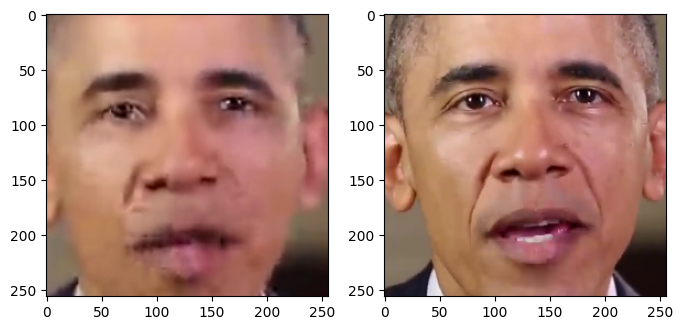

In [103]:
src = train_data[0][0].to(DEVICE)
tar = train_data[0][1].to(DEVICE)
figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1,2,1)
to_pil = ToPILImage()
src_img = to_pil(src.cpu())
print(src_img)
plt.imshow(src_img)
figure.add_subplot(1,2,2)
tar_img = to_pil(tar.cpu())
plt.imshow(tar_img)
plt.show()

In [104]:
src.shape, tar.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [105]:
LEARNING_RATE = 1e-4
EPOCHS = 1

In [106]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bilstm = BiLSTMForAudio(input_size=13, hidden_size=128, num_layers=3)
        self.l_subnet = LSubnet()
        self.v_subnet = VSubnet()
        self.fusion = SpatialAttentionFusion()
        self.unet = UNet()
        
    def forward(self, frame, mfccs, landmarks):
        bi = self.bilstm(mfccs[0])
        bi = bi[:, -1, :]
        self.a_subnet = ASubnet(bi.size(1), bi.size(1))
        audio_features = self.a_subnet(bi[0])
        landmark_features = self.l_subnet(landmarks)
        video_features = self.v_subnet(frame)
        out = self.fusion(audio_features, video_features, landmark_features)
        out = self.unet(out)
        return out.to(DEVICE)

In [107]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter += 1
        image, target, mfcc, landmark = data[0].to(DEVICE),data[1].to(DEVICE),data[2].to(DEVICE), data[3].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image, mfcc, landmark)
        outputs = outputs.squeeze(1)
        target = target.squeeze(1)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image, target, mfcc, landmark = data[0].to(DEVICE),data[1].to(DEVICE),data[2].to(DEVICE), data[3].to(DEVICE)
            outputs = model(image, mfcc, landmark)
            outputs =outputs.squeeze(1)
            target = target.squeeze(1)
            loss = criterion(outputs,target)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [108]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [109]:
from tqdm import tqdm
import torch.optim as optim
from keras.callbacks import EarlyStopping

train_loss = []
val_loss =[]
model = Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.L1Loss()
early_stopper = EarlyStopper(patience=3)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, test_dataloader, val_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, "./model.pth") 
    if early_stopper.early_stop(val_epoch_loss):             
        break
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()

print("\n---------DONE TRAINING----------\n")

Epoch 1 of 1
-------------Training---------------


  0%|          | 19/13903 [00:26<5:20:16,  1.38s/it]


KeyboardInterrupt: 